In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

sc.set_figure_params(dpi_save=300,color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()


from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

import squidpy as sq

from scipy.sparse import csr_array

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/data/person/lab/fengcz/conda/envs/squidpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-21 16:54:23.358540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 16:54:23.487996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-21 16:54:23.528864: E e

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.25.2 scipy==1.11.4 pandas==1.3.5 scikit-learn==1.2.1 statsmodels==0.14.0 python-igraph==0.10.2 pynndescent==0.5.7


/data/person/lab/fengcz/conda/envs/squidpy/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/person/lab/fengcz/conda/envs/squidpy/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
adata = sc.read('./adata_with_coherence_windows5_10_20_100.h5ad')
adata

AnnData object with n_obs × n_vars = 45134 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone', 'purity', 'Windows5', 'Windows10', 'Windows20', 'Windows100'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w

In [3]:
adata.obs.Sample.unique()

['P6_YF_1']
Categories (1, object): ['P6_YF_1']

In [4]:
def calculate_mean_score_across_radii(sample):
    adata_subset = adata[adata.obs.Sample==sample,].copy()

    sq.gr.spatial_neighbors(adata_subset,coord_type='grid',n_rings=5,n_neighs = 8,set_diag=True,key_added='radii5')
    sq.gr.spatial_neighbors(adata_subset,coord_type='grid',n_rings=10,n_neighs = 8,set_diag=True,key_added='radii10')
    sq.gr.spatial_neighbors(adata_subset,coord_type='grid',n_rings=20,n_neighs = 8,set_diag=True,key_added='radii20')
    
    radii5_score = adata_subset.obsp['radii5_connectivities'].dot(csr_array(np.array(adata_subset.obs.Windows10.values).reshape(-1,1)))
    radii5_score = np.multiply(radii5_score.todense(),1/adata_subset.obsp['radii5_connectivities'].sum(axis=1))

    radii10_score = adata_subset.obsp['radii10_connectivities'].dot(csr_array(np.array(adata_subset.obs.Windows10.values).reshape(-1,1)))
    radii10_score = np.multiply(radii10_score.todense(),1/adata_subset.obsp['radii10_connectivities'].sum(axis=1))

    radii20_score = adata_subset.obsp['radii20_connectivities'].dot(csr_array(np.array(adata_subset.obs.Windows10.values).reshape(-1,1)))
    radii20_score = np.multiply(radii20_score.todense(),1/adata_subset.obsp['radii20_connectivities'].sum(axis=1))
    
    adata_subset.obs['radii5_score'] = radii5_score.A1
    adata_subset.obs['radii10_score'] = radii10_score.A1
    adata_subset.obs['radii20_score'] = radii20_score.A1
    
    return(adata_subset.obs)

In [5]:
obss = [calculate_mean_score_across_radii(sample) for sample in tqdm(adata.obs.Sample.unique())]

100%|██████████| 1/1 [01:05<00:00, 65.07s/it]


In [6]:
obs = pd.concat(obss)
adata.obs = obs.loc[adata.obs_names,:].copy()
adata

AnnData object with n_obs × n_vars = 45134 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone', 'purity', 'Windows5', 'Windows10', 'Windows20', 'Windows100', 'radii5_score', 'radii10_score', 'radii20_score'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_

In [7]:
radii5_score_quantile = adata.obs.radii5_score.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
radii5_score_quantile

0.1    0.131215
0.2    0.239949
0.3    0.342433
0.4    0.440084
0.5    0.530301
0.6    0.608106
0.7    0.676476
0.8    0.745405
0.9    0.825696
1.0    1.000000
Name: radii5_score, dtype: float64

In [8]:
radii10_score_quantile = adata.obs.radii10_score.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
radii10_score_quantile

0.1    0.172496
0.2    0.261922
0.3    0.350438
0.4    0.446614
0.5    0.535431
0.6    0.609351
0.7    0.671003
0.8    0.722096
0.9    0.781425
1.0    1.000000
Name: radii10_score, dtype: float64

In [9]:
radii20_score_quantile = adata.obs.radii20_score.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
radii20_score_quantile

0.1    0.209779
0.2    0.290817
0.3    0.356362
0.4    0.416301
0.5    0.523338
0.6    0.594614
0.7    0.677981
0.8    0.712476
0.9    0.755239
1.0    1.000000
Name: radii20_score, dtype: float64

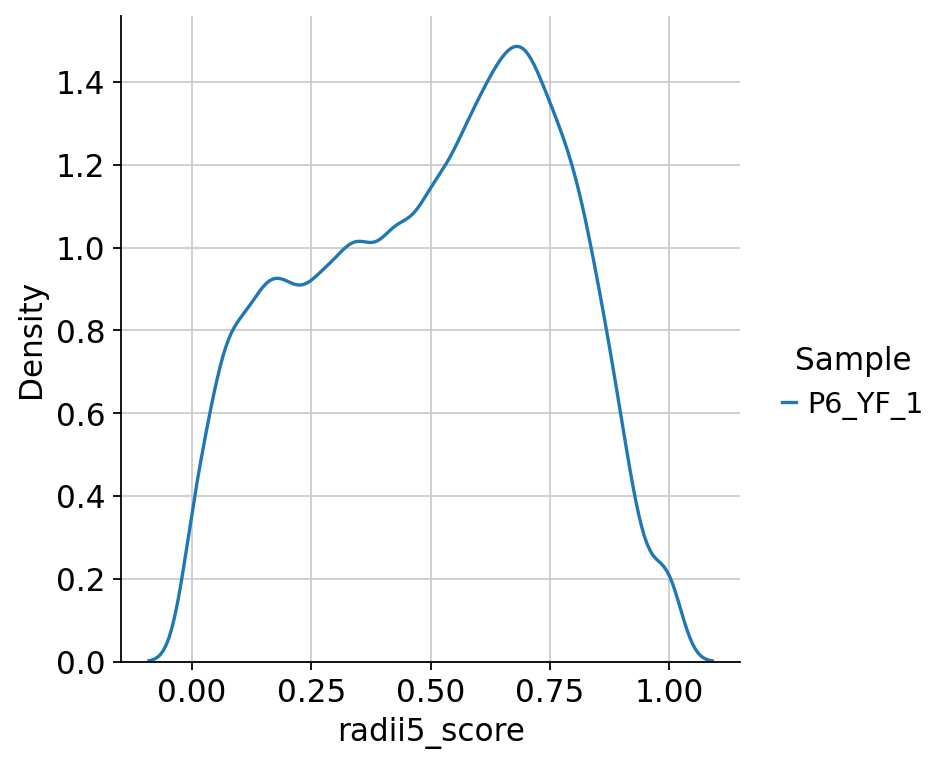

In [10]:
sns.displot(adata.obs, x="radii5_score", hue="Sample", kind="kde")

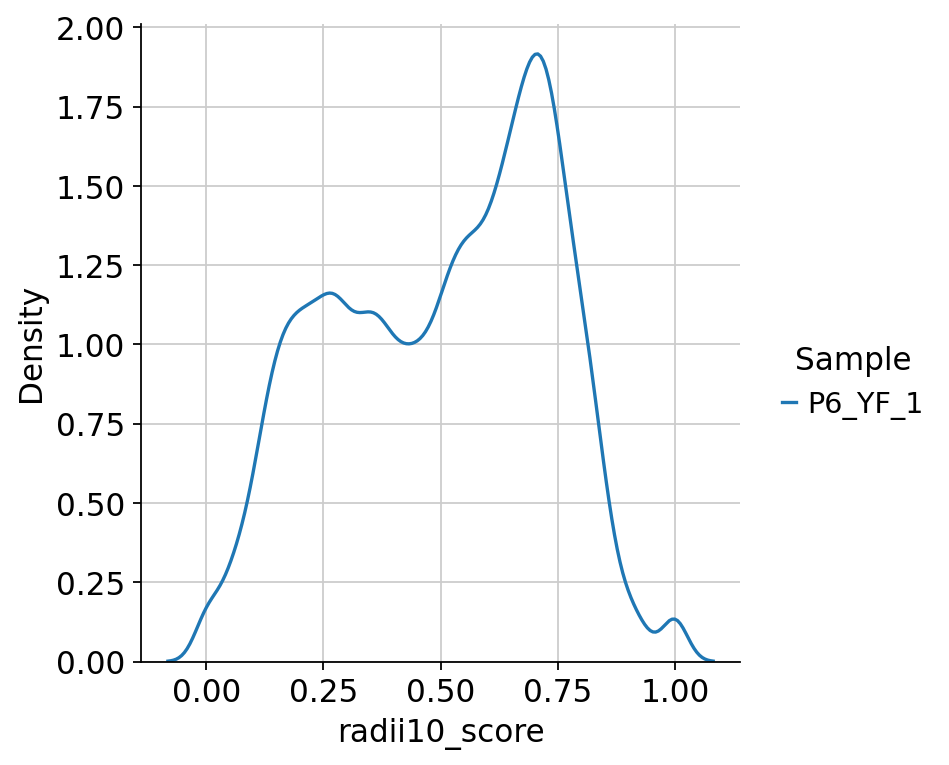

In [11]:
sns.displot(adata.obs, x="radii10_score", hue="Sample", kind="kde")

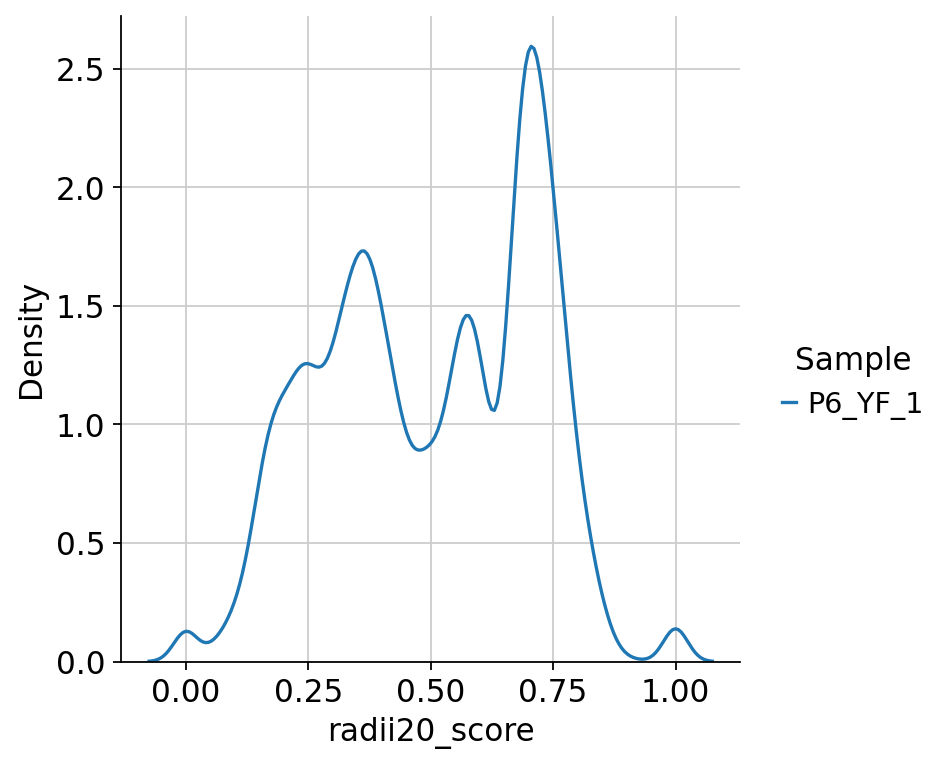

In [12]:
sns.displot(adata.obs, x="radii20_score", hue="Sample", kind="kde")

In [13]:
adata.obs['Structure1st'] = np.where(
    (adata.obs['radii5_score'] > radii5_score_quantile[0.4]) & (adata.obs['radii10_score'] > radii10_score_quantile[0.4]) & (adata.obs['radii20_score'] > radii20_score_quantile[0.4]),
    'Stable',
    np.where(
        (adata.obs['radii5_score'] < radii5_score_quantile[0.4]) & (adata.obs['radii10_score'] < radii10_score_quantile[0.4]) & (adata.obs['radii20_score'] < radii20_score_quantile[0.4]),
        'Unstable',
        'Intermediate'
    )
)
adata.obs['Structure1st'].value_counts()

Stable          23801
Unstable        14876
Intermediate     6457
Name: Structure1st, dtype: int64

In [14]:
adata.write_h5ad('./adata_with_coherence_structure1st.h5ad')

In [15]:
adata.obs.to_csv('./adata_with_coherence_structure1st.csv')

In [16]:
def most_frequent_element(lst):


    unique, counts = np.unique(lst, return_counts=True)


    return unique[np.argmax(counts)]


In [17]:
def calculate_struture2nd(sample):
    adata_subset = adata[adata.obs.Sample==sample,].copy()

    sq.gr.spatial_neighbors(adata_subset,coord_type='grid',n_rings=4,n_neighs = 8,set_diag=True,key_added='radii4')
    
    def calculate_most_frequent_structure(index):
        return(most_frequent_element(adata_subset.obs['Structure1st'][adata_subset.obsp['radii4_connectivities'][index,:].nonzero()[1]]))

    adata_subset.obs['Structure2nd'] = [calculate_most_frequent_structure(index) for index in range(adata_subset.shape[0])]
    
    return(adata_subset.obs)

In [18]:
obss = [calculate_struture2nd(sample) for sample in tqdm(adata.obs.Sample.unique())]

100%|██████████| 1/1 [00:08<00:00,  8.26s/it]


In [19]:
obs = pd.concat(obss)
adata.obs = obs.loc[adata.obs_names,:].copy()
adata

AnnData object with n_obs × n_vars = 45134 × 16147
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'Patient', 'Sample', 'Site', 'X_center', 'Y_center', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'CD4+ T', 'CD8+ T', 'DC', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'M1-like', 'NK', 'Pericytes', 'Plasma cells', 'Macros MRC1', 'Macros SPP1', 'Treg', 'myCAF MMP11+', 'myCAF MMP11-', 'Cell_type_refined', 'Pan-epi', 'Cycling epi', 'Immunoreactive epi', 'Hypoxia epi', 'Normal secretory epi', 'EMT epi', 'Spatial_clone', 'purity', 'Windows5', 'Windows10', 'Windows20', 'Windows100', 'radii5_score', 'radii10_score', 'radii20_score', 'Structure1st', 'Structure2nd'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_

In [20]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0,'#f5d1d1'),(0.25,'#ffadaa'),(0.5,'#ff8780'),(0.75,'#ff5d54'),(1,'#fb2323')]
cmap = LinearSegmentedColormap.from_list('custom_cmap',colors)

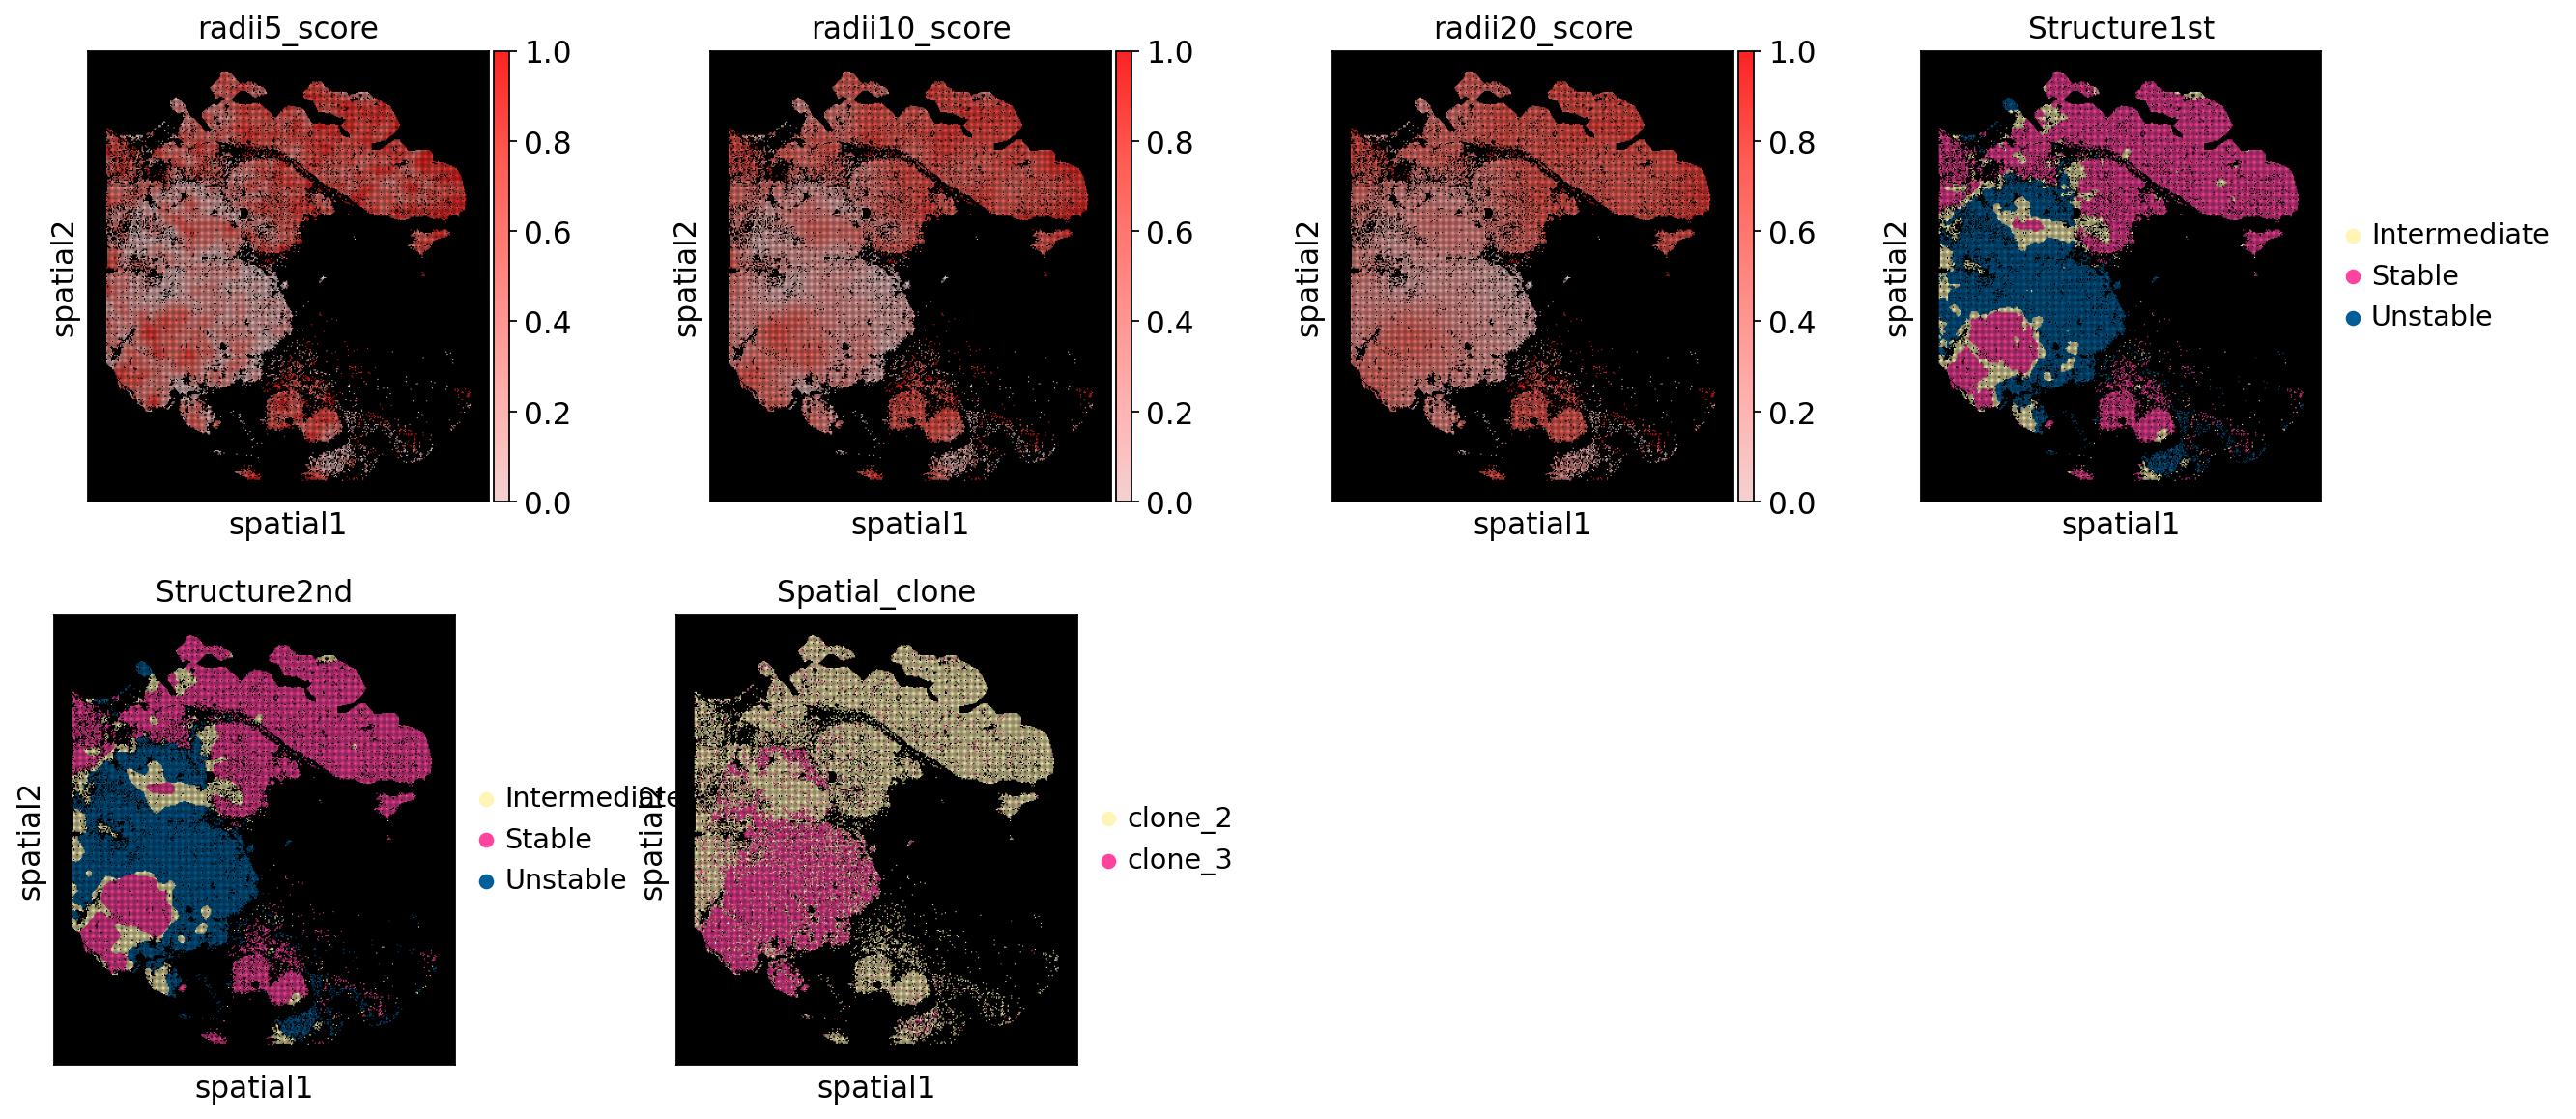

In [21]:
for sample in adata.obs.Sample.unique():
    with mpl.rc_context({'axes.facecolor':'black'}):
        sc.pl.spatial(adata[adata.obs.Sample==sample,].copy(),
             color=['radii5_score','radii10_score','radii20_score','Structure1st','Structure2nd','Spatial_clone'],
             # title=sample,
                      palette=['#FFF5B7','#FF449F','#005F99','#184D47'],
                     cmap=cmap,
                      save=sample+'_structure.pdf',
             spot_size=50)

In [22]:
adata.write_h5ad('./adata_with_coherence_structure2nd.h5ad')

In [23]:
adata.obs.to_csv('./adata_with_coherence_structure2nd.csv')